In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

from keras.preprocessing.image import random_rotation, random_shift

%matplotlib inline

data_path = '/home/ubuntu/fs/data/luna16/'
scan_path = data_path+'scans/'
csv_path = data_path+'csvfiles/annotations.csv'

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Helper Functions

See luna_eda notebook for details

In [2]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return numpyImage, numpyOrigin, numpySpacing

In [3]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    strechedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = strechedVoxelCoord / spacing
    return voxelCoord.astype(int)

In [4]:
def make_mask(dims, diameter, width, height):
    img = np.zeros((width, height), np.uint8)
    cv2.circle(img, dims, int(diameter), (1,1,1), -1)
    return img

In [5]:
def segment_lungs(img):
    
    # normalize
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # remove overflow and underflow, set to mean
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    img[img==max]=mean
    img[img==min]=mean
    
    # cluster and threshold
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    # smooth and label regtions
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    
    # make good mask from good regions, numbers from tutorial
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<480 and B[3]-B[1]<480 and B[0]>40 and B[2]<477:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0

    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10]))
    
    # multiply by mask
    img = mask*img

    # renormalizing the masked image
    new_mean = np.mean(img[mask>0])  
    new_std = np.std(img[mask>0])
    #
    #  Pushing the background color up to the lower end
    #  of the pixel range for the lungs
    #
    old_min = np.min(img)       # background color
    img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
    img = img-new_mean
    img = img/new_std
    
    return img

## Batch Iterator

In [6]:
img_width = 512
img_height = 512

class lunaIterator(object):
    
    def __init__(self, df, batch_size=32, shuffle=False, seed=None, rot_range=10, shift_range=0.05):
        self.df = df
        self.n = len(df)-1
        self.batch_size = batch_size
        self.batch_index = 0
        self.rot_range = rot_range
        self.shift_range = shift_range
        
        self.index_generator = self._gen_index(self.n, batch_size, shuffle, seed)
        
    def reset(self):
        self.batch_index = 0
        
    def _gen_index(self, n , batch_size=32, shuffle=False, seed=None):
        
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)
                    
            current_index = (self.batch_index * batch_size) % n
            if n >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = batch_size
                self.batch_index = 0
            yield(index_array[current_index: current_index + current_batch_size],
                     current_index, current_batch_size)
            
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        
        index_array, current_index, current_batch_size = next(self.index_generator)
        
        lungs = np.ndarray([current_batch_size, 1, img_width, img_height])
        masks = np.ndarray([current_batch_size, 1, img_width, img_height])
        for i in range(0, current_batch_size):
            # get image data and file
            ann = self.df.iloc[index_array[i]]
            filename = scan_path+ann['seriesuid']+'.mhd'
            image, origin, spacing = load_itk_image(filename)
            
            # get voxelCoords
            worldCoord = np.asarray([ann['coordZ'], ann['coordY'], ann['coordX']])
            voxelCoord = worldToVoxelCoord(worldCoord, origin, spacing)
            
            # segment lungs and make mask
            lungs[i, 0] = segment_lungs(image[voxelCoord[0]])
            masks[i, 0] = make_mask((voxelCoord[2], voxelCoord[1]), ann['diameter_mm'],
               img_width, img_height)
            
            # random shifts/rotations
            img_stack = np.stack([lungs[i, 0], masks[i, 0]])
            img_stack = random_rotation(img_stack, self.rot_range)
            img_stack = random_shift(img_stack, self.shift_range, self.shift_range)
            lungs[i, 0] = img_stack[0]
            masks[i, 0] = img_stack[1]
            
        return lungs, masks

## Test

In [7]:
df = pd.read_csv(csv_path)
idx = df.groupby('seriesuid')['diameter_mm'].transform(max) == df['diameter_mm']
df_max = df[idx]

In [12]:
gen = lunaIterator(df_max, batch_size=2, shuffle=True, rot_range=0, shift_range=0.0)

In [9]:
def print_batch(batch):
    for lung, mask in zip(batch[0], batch[1]):
        fig, ax = plt.subplots(2,2,figsize=[10,10])
        ax[0,0].imshow(lung[0], cmap=plt.cm.gray)
        ax[0,1].imshow(mask[0], cmap=plt.cm.gray)
        ax[1,0].imshow(lung[0]*mask[0], cmap=plt.cm.gray)
        plt.show()

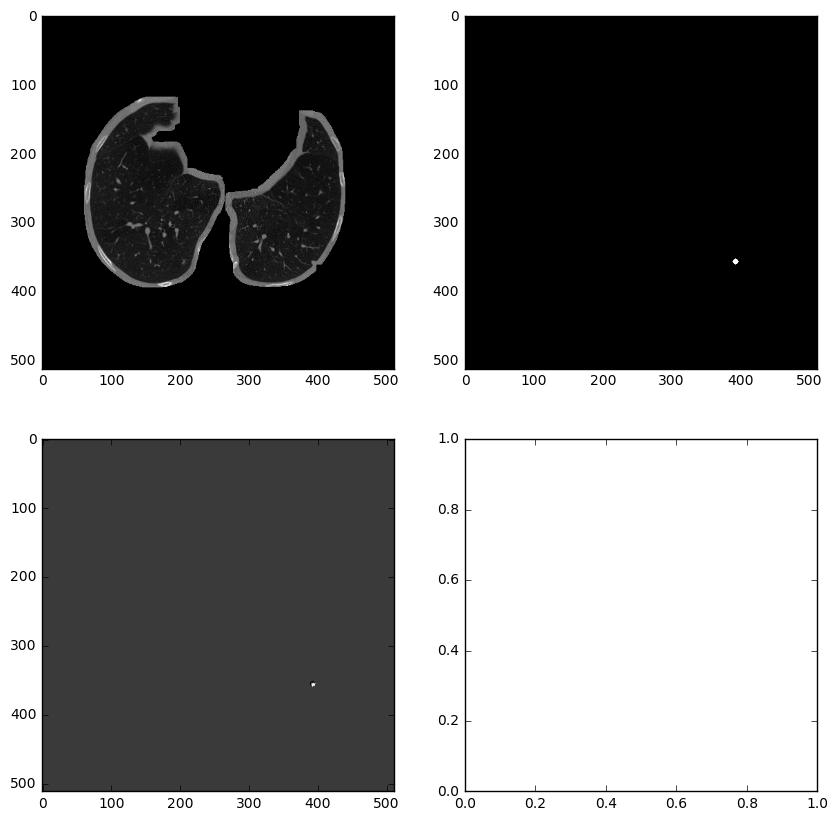

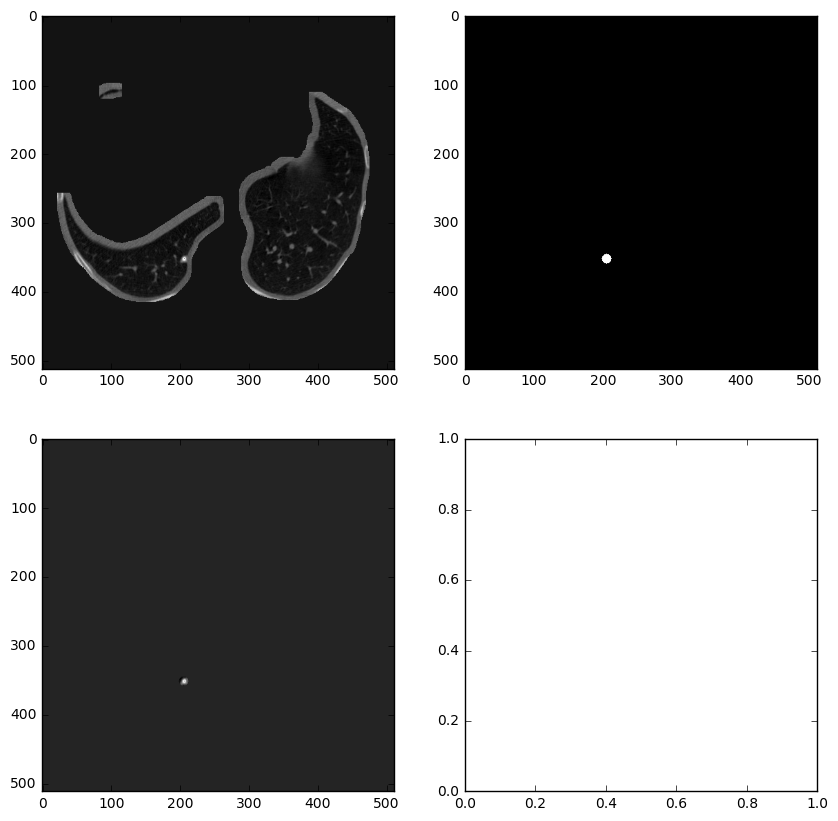

In [14]:
batch = next(gen)
print_batch(batch)